# Fiancial and Economic scoring model with LSTM

## Importing Libraries


In [ ]:
%load_ext autoreload
%autoreload 2
import pandas as pd, pyarrow
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import mlflow

from torch.utils.data import DataLoader
import boto3
import io
import torch

from pathlib import Path
from datetime import datetime
from dotenv import load_dotenv
from mlflow.tracking import MlflowClient
import ast
import joblib
# --- Настройка путей и sys.path ---
# Добавляем корневую директорию проекта в sys.path для импорта кастомных модулей
PROJECT_ROOT = Path().cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.config import config
from src.logger import logger
from src.database import clickhouse_engine, postgres_engine, ipdr_engine    
from src.visualization import *
from src.predprocessing_lstm import _process_group, create_lstm_sequences_credit_scoring, convert_categorical_to_str, collate_fn
from src.base_models import LSTMCreditScoringDataset
from src.modeling_lstm import _predict_probs_from_loader


2025-11-06 11:39:43,239 | my_logger - INFO - ✅ PostgreSQL engine создан | /data/aturov/scoring/src/database.py:21


Configuration loaded successfully.


2025-11-06 11:39:43,265 | my_logger - INFO - ✅ ClickHouse engine создан | /data/aturov/scoring/src/database.py:36
2025-11-06 11:39:43,266 | my_logger - INFO - ✅ IPDR ClickHouse engine создан | /data/aturov/scoring/src/database.py:46


In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
logger.info(f"Using device: {device}")

2025-11-06 11:39:44,362 | my_logger - INFO - Using device: cuda | /tmp/ipykernel_338229/1906506296.py:7


In [3]:
logger.info("MLflow client created and tracking URI set.")

mlflow.set_tracking_uri(config.mlflow_config.HOST_MLFLOW)


client = MlflowClient()

exp = client.get_experiment_by_name(config.mlflow_config.NAME_PROJECT)
if exp is None:
    # create_experiment поддерживает tags
    try:
        exp_id = client.create_experiment(config.mlflow_config.NAME_PROJECT, tags={"model": config.mlflow_config.NAME_MODEL_CLIENT})
    except Exception:
        # race: если кто-то создал эксперимент параллельно — получить его
        exp = client.get_experiment_by_name(config.mlflow_config.NAME_PROJECT)
        exp_id = exp.experiment_id if exp else None
    if exp_id:
        exp = client.get_experiment(exp_id)

# установить/обновить теги и описание (описание в UI хранится как тег "mlflow.note.content")
if exp is not None:
    client.set_experiment_tag(exp.experiment_id, "model", config.mlflow_config.NAME_MODEL_CLIENT)
    if config.mlflow_config.EXPERIMENT_DESCRIPTION:
        client.set_experiment_tag(exp.experiment_id, "mlflow.note.content", config.mlflow_config.EXPERIMENT_DESCRIPTION)

# сделать эксперимент активным
mlflow.set_experiment(config.mlflow_config.NAME_PROJECT)
exp_id = mlflow.get_experiment_by_name(config.mlflow_config.NAME_PROJECT).experiment_id


2025-11-06 11:39:44,394 | my_logger - INFO - MLflow client created and tracking URI set. | /tmp/ipykernel_338229/2002293533.py:1


In [4]:
version_info = client.get_model_version_by_alias(name=config.mlflow_config.NAME_MODEL_CLIENT, alias='test')
run_id = version_info.run_id
logger.info(f"Найден run_id по алиасу 'test': {run_id}")


2025-11-06 11:39:44,659 | my_logger - INFO - Найден run_id по алиасу 'test': ec0536e42419435895f30950d76e651a | /tmp/ipykernel_338229/1589788988.py:3


In [5]:
optimal_threshold = client.get_run(run_id).data.params.get('optimal_threshold')
optimal_f1_threshold = client.get_run(run_id).data.params.get('optimal_f1_threshold')
optimal_f1_threshold, optimal_threshold

('0.4601399004459381', '0.29767337441444397')

In [6]:
run_id

'ec0536e42419435895f30950d76e651a'

## Download datasets

In [7]:
SPLINT_DATE = client.get_run(run_id).data.params.get('split_date')
DATE_END = client.get_run(run_id).data.params.get('date_end')
NAME_DATAFRAME = client.get_run(run_id).data.params.get('name_dataframe')
COUNT_WEEKS = client.get_run(run_id).data.params.get('count_weeks')
OVERDUE_DAYS_MAX = client.get_run(run_id).data.params.get('overdue_days_max')
TOTAL_OVERDUE = client.get_run(run_id).data.params.get('total_overdue')
NAME_DATAFRAME_WEEKS = f'{NAME_DATAFRAME}_{COUNT_WEEKS}_{OVERDUE_DAYS_MAX}_{TOTAL_OVERDUE}' # имя файла с признаками по неделям for LSTMs models
DATE_FEATURES = client.get_run(run_id).data.params.get('date_features')
KEYS_COLUMNS = ast.literal_eval(client.get_run(run_id).data.params.get('name_columns'))
CURRENT_DATE = datetime.now().strftime('%Y%m%d')
TARGET_COL = 'target'
SEQ_COL = 'count_weeks'

In [8]:
df = pd.read_parquet(config.environment.data_processed_path / f'{NAME_DATAFRAME_WEEKS}_{DATE_FEATURES}.parquet')

logger.info(f"Train shape: {df.shape}")
logger.info(f"Train target distribution:\n{df.query('count_weeks == 1')['target'].value_counts()}")

id_cols = list(df.index.names.copy())
df = df.reset_index()
id_cols = id_cols + [SEQ_COL] + [TARGET_COL]
df = df.set_index(id_cols)

if KEYS_COLUMNS is not None:
    df = df[KEYS_COLUMNS].copy()
    
    
val_tab_full = df[(df.index.get_level_values('date_open') >= pd.to_datetime(SPLINT_DATE))]
val_tab_full.to_parquet(config.environment.data_final_path / f'{NAME_DATAFRAME_WEEKS}_val_{CURRENT_DATE}.parquet')
logger.info(f"valid shape: {val_tab_full.shape}")
logger.info(f"Valid target distribution:\n{val_tab_full.index.get_level_values(TARGET_COL).value_counts()}")
oot_tab = df[df.index.get_level_values('date_open') >= pd.to_datetime(DATE_END)]
oot_tab.to_parquet(config.environment.data_final_path / f'{NAME_DATAFRAME_WEEKS}_oot_{CURRENT_DATE}.parquet')
logger.info(f"OOT shape: {oot_tab.shape}")
logger.info(f"OOT target distribution:\n{oot_tab.index.get_level_values(TARGET_COL).value_counts()}")




2025-11-06 11:39:45,273 | my_logger - INFO - Train shape: (221310, 94) | /tmp/ipykernel_338229/2924920534.py:3
2025-11-06 11:39:45,330 | my_logger - INFO - Train target distribution:
target
0    12426
1     6201
Name: count, dtype: int64 | /tmp/ipykernel_338229/2924920534.py:4
2025-11-06 11:39:46,211 | my_logger - INFO - valid shape: (80415, 20) | /tmp/ipykernel_338229/2924920534.py:17
2025-11-06 11:39:46,214 | my_logger - INFO - Valid target distribution:
target
1    68278
0    12137
Name: count, dtype: int64 | /tmp/ipykernel_338229/2924920534.py:18
2025-11-06 11:39:46,334 | my_logger - INFO - OOT shape: (64979, 20) | /tmp/ipykernel_338229/2924920534.py:21
2025-11-06 11:39:46,337 | my_logger - INFO - OOT target distribution:
target
1    64883
0       96
Name: count, dtype: int64 | /tmp/ipykernel_338229/2924920534.py:22


In [9]:
def make_query(engine):
    """
    Функция для выполнения SQL-запроса к базе данных и получения данных в виде DataFrame.
    Параметры:
    - engine: SQLAlchemy engine для подключения к базе данных.
    Возвращает:
    - DataFrame с результатами запроса.
    """

    query = f"""
            SELECT 
                *
            FROM data_science.credits_subs_eldik_clean AS ce
        
    """

    data = pd.read_sql(query, engine)

    return data
df_part = make_query(clickhouse_engine)
df_part = df_part.drop_duplicates(subset=['id_request', 'subscription_id', 'phone_eldik', 'inn_eldik','id_credit'])
df_part = df_part[['id_request', 'subscription_id', 'phone_eldik', 'inn_eldik',
       'id_credit', 'date_open', 'summa','overdue_max','total_overdue', 'status']]
df_part['date_open'] = pd.to_datetime(df_part['date_open']).dt.date 
logger.info(f"Shape of df_part: {df_part.shape}")

2025-11-06 11:39:46,947 | my_logger - INFO - Shape of df_part: (18631, 10) | /tmp/ipykernel_338229/3932288387.py:25


In [10]:
run_id

'ec0536e42419435895f30950d76e651a'

In [11]:
s3_client = boto3.client(
    's3',
    endpoint_url=config.mlflow_config.MINIO_ENDPOINT,
    aws_access_key_id=config.mlflow_config.AWS_ACCESS_KEY_ID,
    aws_secret_access_key=config.mlflow_config.AWS_SECRET_ACCESS_KEY,
)

# Функция для загрузки файла из MinIO в память
def load_from_s3(bucket, key):
    response = s3_client.get_object(Bucket=bucket, Key=key)
    data = response['Body'].read()
    return io.BytesIO(data)

# Загрузка файлов напрямую
prefix = f"{exp_id}/{run_id}/artifacts/preprocessor"

cat_maps = joblib.load(load_from_s3(config.mlflow_config.BUCKET_NAME, f"{prefix}/cat_maps.pkl"))
preprocessor = joblib.load(load_from_s3(config.mlflow_config.BUCKET_NAME, f"{prefix}/preprocessor_lstm_{DATE_FEATURES}.joblib"))

numeric_cols = joblib.load(load_from_s3(config.mlflow_config.BUCKET_NAME, f"{prefix}/numeric_cols.pkl"))
categorical_cols = joblib.load(load_from_s3(config.mlflow_config.BUCKET_NAME, f"{prefix}/categorical_cols.pkl"))

logger.info(f"Numeric cols: {len(numeric_cols)}, categorical cols: {len(categorical_cols)}")

2025-11-06 11:39:47,114 | my_logger - INFO - Numeric cols: 16, categorical cols: 4 | /tmp/ipykernel_338229/3885913668.py:23


In [12]:
version_info

<ModelVersion: aliases=['test'], creation_timestamp=1762402581652, current_stage='None', deployment_job_state=<ModelVersionDeploymentJobState: current_task_name='', job_id='', job_state='DEPLOYMENT_JOB_CONNECTION_STATE_UNSPECIFIED', run_id='', run_state='DEPLOYMENT_JOB_RUN_STATE_UNSPECIFIED'>, description='', last_updated_timestamp=1762402581652, metrics=None, model_id=None, name='LSTM_Scoring', params=None, run_id='ec0536e42419435895f30950d76e651a', run_link='', source='s3://mlflow/3/models/m-79d7885beb054a37b9285232c681fc6b/artifacts', status='READY', status_message=None, tags={}, user_id='', version='6'>

In [13]:
model_key = version_info.source.replace(f's3://{config.mlflow_config.BUCKET_NAME}/', '') + '/data/model.pth'

response = s3_client.get_object(Bucket=config.mlflow_config.BUCKET_NAME, Key=model_key)
model_buffer = io.BytesIO(response['Body'].read())
model = torch.load(model_buffer, map_location=device, weights_only=False)
logger.info(f"Loaded model: {model}")

/data/aturov/scoring/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:827: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2025-11-06 11:39:47,335 | my_logger - INFO - Loaded model: LSTMModel(
  (embs): ModuleList(
    (0): Embedding(5, 2)
    (1): Embedding(6, 2)
    (2): Embedding(13, 3)
    (3): Embedding(5, 2)
  )
  (lstm): LSTM(25, 128, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
) | /tmp/ipykernel_338229/1697114400.py:6


## Get probabilities from the model

In [14]:
# Приводим категории к строковому типу, чтобы избежать ошибок при маппинге
val_tab_full = convert_categorical_to_str(val_tab_full, categorical_cols)

# Определяем ID колонки для группировки
id_cols_from_index = list(val_tab_full.index.names)
id_cols = [col for col in id_cols_from_index if col not in [config.features.SEQ_COL, config.features.TARGET_COL]]
logger.info(f"ID columns for grouping: {id_cols}")

/data/aturov/scoring/src/predprocessing_lstm.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str)
/data/aturov/scoring/src/predprocessing_lstm.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str)
/data/aturov/scoring/src/predprocessing_lstm.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [15]:
# Создаем последовательности для validation
Xn_val, Xc_val, y_val_seq, val_metadata, val_len = create_lstm_sequences_credit_scoring(
    df=val_tab_full,
    id_cols=id_cols,
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols,
    cat_maps=cat_maps,
    scaler=preprocessor, 
    seq_col=config.features.SEQ_COL,
    target_col=config.features.TARGET_COL
)

2025-11-06 11:39:48,780 | my_logger - INFO - Найдено 6712 уникальных групп для обработки на нескольких ядрах. | /data/aturov/scoring/src/predprocessing_lstm.py:60
Создание последовательностей:   1%|          | 64/6712 [00:00<00:24, 273.13it/s]

Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.Configuration loaded successfully.

Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded

Создание последовательностей:   3%|▎         | 192/6712 [00:02<01:23, 78.53it/s]

Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.


Создание последовательностей: 100%|██████████| 6712/6712 [00:05<00:00, 1181.06it/s]
2025-11-06 11:39:54,863 | my_logger - INFO - Созданы списки последовательностей: 6712 шт. | /data/aturov/scoring/src/predprocessing_lstm.py:75


In [16]:
val_dataset = LSTMCreditScoringDataset(Xn_val, Xc_val, y_val_seq, val_len, val_metadata)
logger.info(f"Val dataset: {len(val_dataset)} samples")
# ← Проверяем типы данных в батче
sample_batch = next(iter(DataLoader(val_dataset, batch_size=4)))
logger.info(f"Sample batch dtypes:")
logger.info(f"  X_num dtype: {sample_batch['X_num'].dtype}")
logger.info(f"  X_cat dtype: {sample_batch['X_cat'].dtype}")
logger.info(f"  y dtype: {sample_batch['y'].dtype}")
logger.info(f"  y values: {sample_batch['y']}")

va_loader_pred = DataLoader(
    val_dataset,
    batch_size=config.lstm.BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    pin_memory=True
)

logger.info(f"Val loader: {len(va_loader_pred)} batches")

2025-11-06 11:39:54,931 | my_logger - INFO - Val dataset: 6712 samples | /tmp/ipykernel_338229/538504923.py:2
2025-11-06 11:39:54,934 | my_logger - INFO - Sample batch dtypes: | /tmp/ipykernel_338229/538504923.py:5
2025-11-06 11:39:54,935 | my_logger - INFO -   X_num dtype: torch.float32 | /tmp/ipykernel_338229/538504923.py:6
2025-11-06 11:39:54,935 | my_logger - INFO -   X_cat dtype: torch.int64 | /tmp/ipykernel_338229/538504923.py:7
2025-11-06 11:39:54,936 | my_logger - INFO -   y dtype: torch.float32 | /tmp/ipykernel_338229/538504923.py:8
2025-11-06 11:39:54,938 | my_logger - INFO -   y values: tensor([0., 1., 0., 1.]) | /tmp/ipykernel_338229/538504923.py:9
2025-11-06 11:39:54,939 | my_logger - INFO - Val loader: 105 batches | /tmp/ipykernel_338229/538504923.py:19


In [17]:
# Функция для получения предсказаний вероятностей из DataLoader
val_probs   = _predict_probs_from_loader(va_loader_pred, model, device)
val_probs


array([0.36248672, 0.5701043 , 0.27551547, ..., 0.26467496, 0.3481272 ,
       0.2076731 ], shape=(6712,), dtype=float32)

In [18]:
meta_df_valid = val_dataset.metadata.copy()
meta_df_valid = meta_df_valid.reset_index(drop=True)
meta_df_valid['target'] = val_dataset.y.numpy().astype(int)
meta_df_valid['prob'] = val_probs.astype(float)
meta_df_valid['date_open'] = pd.to_datetime(meta_df_valid['date_open']).dt.date
meta_df_valid.head(3)

,id_request,subscription_id,phone_eldik,inn_eldik,id_credit,date_open,target,prob
0,000c0c7d-b1cd-48f3-acde-801f7b97559a,994037,996777508060,21512199400187,100000012131,2025-02-20,0,0.362487
1,001c77be-2bc9-4a6e-9777-8ea1c347653f,19259632,996221620919,22507200350228,683daa2b4b8c5bec441248a2,2025-06-02,1,0.570104
2,00219d9a-2361-4dba-b30c-3c2dc106826c,862494,996778424022,11612197800846,2900000003814,2024-12-24,0,0.275515


In [19]:
data = meta_df_valid.merge(
    df_part,
    how='left',
    on=['id_request', 'subscription_id', 'phone_eldik', 'inn_eldik','id_credit', 'date_open']
)
data.shape

(6712, 12)

In [20]:
data_issue = data[data['status'] == 'Одобрено'].copy()
data_non_issue = data[data['status'] != 'Одобрено'].copy()
data_issue.shape, data_non_issue.shape

((1027, 12), (5685, 12))

In [21]:
optimal_threshold

'0.29767337441444397'

In [22]:
# Оптимальный порог для классификации для данной модели из MLflow из параметров модели
thresholds = [optimal_threshold, optimal_f1_threshold, 0.2, 0.22, 0.25, 0.28, 0.32, 0.33, 0.35, 0.38, 0.4, 0.42, 0.45, 0.5]

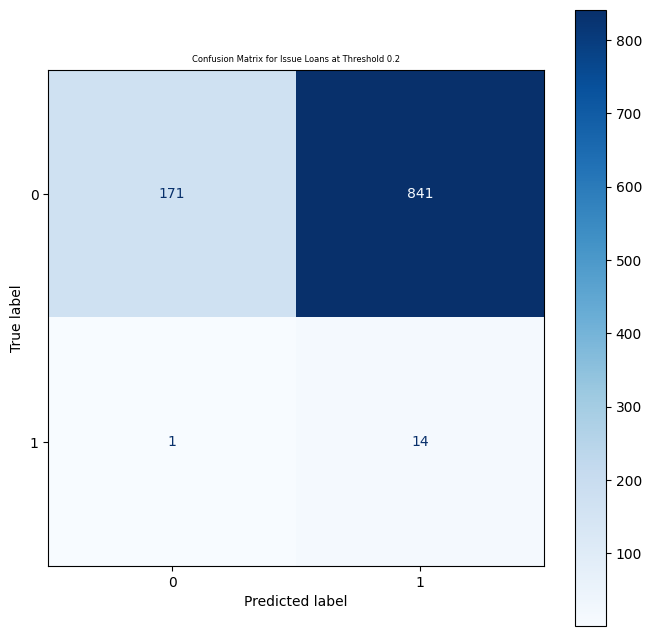

In [23]:
threshold_round = 0.2

fig, path = plot_confusion_matrix(data_issue.target, data_issue.prob, threshold_round, 
                                save_flg=False, show_flg=True, 
                                filename=f'confusion_matrix_issue_{threshold_round}.png', 
                                title_text=f'Confusion Matrix for Issue Loans at Threshold {threshold_round}')


In [24]:
from sklearn.metrics import roc_auc_score

auc_roc_issue = roc_auc_score(data_issue.target, data_issue.prob)
with mlflow.start_run(run_id=run_id):
    mlflow.log_metric('auc_roc_issue', auc_roc_issue)
logger.info(f"AUC-ROC for issued loans: {auc_roc_issue}")

2025-11-06 11:39:55,876 | my_logger - INFO - AUC-ROC for issued loans: 0.6059947299077734 | /tmp/ipykernel_338229/2207293237.py:6


🏃 View run wistful-bird-61 at: http://10.16.230.222:5000/#/experiments/3/runs/ec0536e42419435895f30950d76e651a
🧪 View experiment at: http://10.16.230.222:5000/#/experiments/3


In [25]:
def calculate_metrics(name_datasets, data, threshold, flag_issue=False): 
    ''' Функция для расчета метрик по данным при заданном пороге классификации '''
    threshold = float(threshold)  # Преобразуем в float
    optimal_threshold_round = round(threshold, 2)
    # Посчитаем уровень одобрения по матрице
    approval_rate = data[data.prob < threshold].shape[0] / data.shape[0]
    # Посчитам процент дефолтов среди одобренных моделью
    if flag_issue:
        default_rate = data[(data.prob < threshold) & (data.target == 1)].shape[0] / data[data.prob < threshold].shape[0] if data[data.prob < threshold].shape[0] > 0 else 0.0
        default_rate_summa = data[(data.prob < threshold) & (data.target == 1)]['summa'].sum() / data[data.prob < threshold]['summa'].sum() if data[data.prob < threshold]['summa'].sum() > 0 else 0.0
        default_summa = data[(data.prob < threshold) & (data.target == 1)]['summa'].sum()/1000000
    else:
        default_rate = None
        default_rate_summa = None
        default_summa = None

    # Посчитаем сумму одобренных моделью и процент одобрения по сумме
    approval_rate_summa = data[data.prob < threshold]['summa'].sum() / data['summa'].sum()
    approval_summa = data[data.prob < threshold]['summa'].sum()/1000000
    # Посчитам процент дефолтов среди одобренных моделью
    # Рассчитаем метрики для не одобренных заявок моделью. Сколько из тех кому было выдано - модель не выдала
    if flag_issue:
        non_approval_model_good = data[(data.prob >= threshold) & (data.target == 0)].shape[0]
        non_approval_model_good_summa = data[(data.prob >= threshold) & (data.target == 0)]['summa'].sum()/1000000
    return {
        'Имя выборки для анализа': name_datasets,
        'При пороге >= - плохие': optimal_threshold_round,
        'Уровень одобрения(кол-во)': round(approval_rate, 4),
        'Уровень одобрения(сумма)': round(approval_rate_summa, 4),
        'Одобренная сумма(млн)': round(approval_summa, 2),
        'Уровень дефолта(кол-во)': round(default_rate, 4) if flag_issue else None,
        'Уровень дефолта(сумма)': round(default_rate_summa, 4) if flag_issue else None,
        'Дефолтная сумма(млн)': round(default_summa, 2) if flag_issue else None,
        'Хорошие кому не будет выдано(кол-во)': round(non_approval_model_good, 2) if flag_issue else None,
        'Хорошие кому не будет выдано(млн)': round(non_approval_model_good_summa, 2) if flag_issue else None
    }
results = []
for thr in thresholds:
    metrics = calculate_metrics('Выданные кредиты', data_issue, thr, flag_issue=True)
    results.append(metrics)
    metrics_no_issue = calculate_metrics('Не выданные заявки', data_non_issue, thr, flag_issue=False)
    results.append(metrics_no_issue)


In [26]:
pd.DataFrame(results).to_excel(config.environment.data_final_path / f'financial_metrics_lstm_{config.features.DATE_FEATURES}.xlsx', index=False)
fin_data = pd.DataFrame(results)
fin_data.head(3)

,Имя выборки для анализа,При пороге >= - плохие,Уровень одобрения(кол-во),Уровень одобрения(сумма),Одобренная сумма(млн),Уровень дефолта(кол-во),Уровень дефолта(сумма),Дефолтная сумма(млн),Хорошие кому не будет выдано(кол-во),Хорошие кому не будет выдано(млн)
0,Выданные кредиты,0.30,0.5385,0.5945,211.29,0.0127,0.0088,1.86,466.0,142.45
1,Не выданные заявки,0.30,0.1594,0.1977,62.54,NaN,NaN,NaN,NaN,NaN
2,Выданные кредиты,0.46,0.9211,0.9393,333.85,0.0116,0.0073,2.45,77.0,20.48


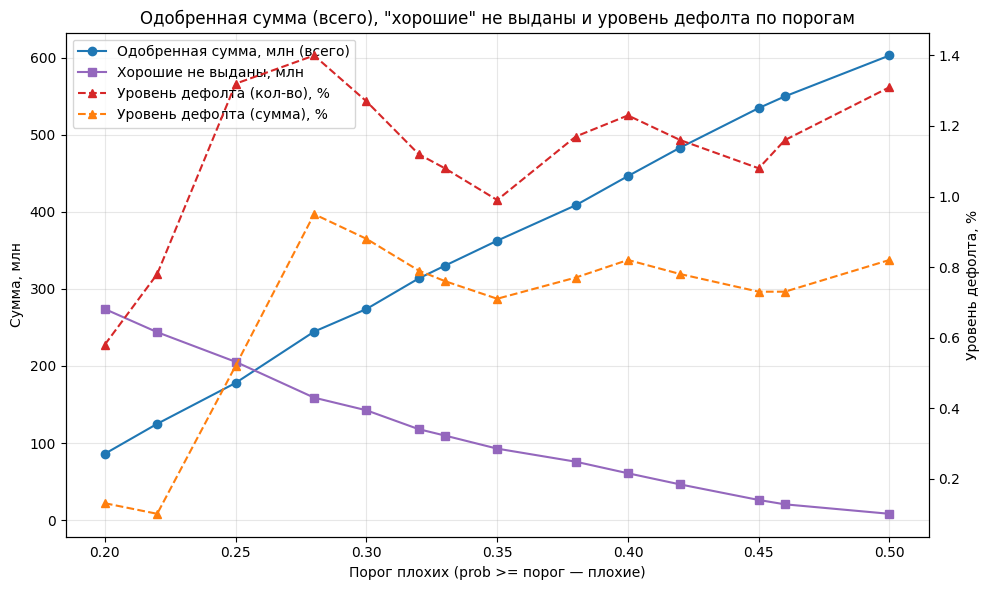

🏃 View run wistful-bird-61 at: http://10.16.230.222:5000/#/experiments/3/runs/ec0536e42419435895f30950d76e651a
🧪 View experiment at: http://10.16.230.222:5000/#/experiments/3


Exception in thread Thread-6 (bg_main):
Traceback (most recent call last):
  File "/tmp/ipykernel_338229/2263935204.py", line 17, in bg_main
  File "/data/aturov/scoring/.venv/lib/python3.10/site-packages/IPython/core/display_functions.py", line 374, in update
    update_display(obj, display_id=self.display_id, **kwargs)
  File "/data/aturov/scoring/.venv/lib/python3.10/site-packages/IPython/core/display_functions.py", line 326, in update_display
    display(obj, display_id=display_id, **kwargs)
  File "/data/aturov/scoring/.venv/lib/python3.10/site-packages/IPython/core/display_functions.py", line 296, in display
    publish_display_data(data=obj, metadata=metadata, **kwargs)
  File "/data/aturov/scoring/.venv/lib/python3.10/site-packages/IPython/core/display_functions.py", line 93, in publish_display_data
    display_pub.publish(
  File "/data/aturov/scoring/.venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 135, in publish
    msg = self.session.msg(msg_type, json_clean

In [ ]:
# Берём только строки для 'Выданные кредиты' и сортируем по порогу
df_issue = fin_data.query('`Имя выборки для анализа` == "Выданные кредиты"') \
                  .sort_values('При пороге >= - плохие') \
                  .reset_index(drop=True)

# Суммарная одобренная сумма = сумма по всем выборкам (выданные + не выданные)
totals = (
    fin_data
    .groupby('При пороге >= - плохие', as_index=False)['Одобренная сумма(млн)']
    .sum()
    .sort_values('При пороге >= - плохие')
    .reset_index(drop=True)
)

# Объединяем, чтобы все линии были выровнены по одинаковым порогам
df_plot = df_issue.merge(totals, on='При пороге >= - плохие', suffixes=('', '_total'))

x = df_plot['При пороге >= - плохие'].astype(float)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Левая ось: суммарная одобренная сумма (включая "Не выданные") и хорошие не выданы
ax1.plot(x, df_plot['Одобренная сумма(млн)_total'], marker='o', color='tab:blue', label='Одобренная сумма, млн (всего)')
ax1.plot(x, df_plot['Хорошие кому не будет выдано(млн)'], marker='s', color='tab:purple', label='Хорошие не выданы, млн')
ax1.set_xlabel('Порог плохих (prob >= порог — плохие)')
ax1.set_ylabel('Сумма, млн')
ax1.grid(alpha=0.3)

# Правая ось: уровень дефолта (кол-во) и по сумме в процентах (берём из секции "Выданные кредиты")
ax2 = ax1.twinx()
ax2.plot(x, df_plot['Уровень дефолта(кол-во)'] * 100, marker='^', color='tab:red', linestyle='--', label='Уровень дефолта (кол-во), %')
ax2.plot(x, df_plot['Уровень дефолта(сумма)'] * 100, marker='^', color='tab:orange', linestyle='--', label='Уровень дефолта (сумма), %')
ax2.set_ylabel('Уровень дефолта, %')

# Легенда (объединяем обе оси)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Одобренная сумма (всего), "хорошие" не выданы и уровень дефолта по порогам')
plt.tight_layout()

out_path = config.environment.artifacts_dir / run_id / f'approval_default_vs_threshold_with_good_{config.features.DATE_FEATURES}.png'
os.makedirs(out_path.parent, exist_ok=True)
plt.savefig(out_path, dpi=150)
plt.show()

with mlflow.start_run(run_id=run_id):
    mlflow.log_artifact(str(out_path), artifact_path='plots')


In [30]:
optimal_f1_threshold

'0.4601399004459381'

In [32]:
fin_data[fin_data['При пороге >= - плохие'] == 0.3]

,Имя выборки для анализа,При пороге >= - плохие,Уровень одобрения(кол-во),Уровень одобрения(сумма),Одобренная сумма(млн),Уровень дефолта(кол-во),Уровень дефолта(сумма),Дефолтная сумма(млн),Хорошие кому не будет выдано(кол-во),Хорошие кому не будет выдано(млн)
0,Выданные кредиты,0.3,0.5385,0.5945,211.29,0.0127,0.0088,1.86,466.0,142.45
1,Не выданные заявки,0.3,0.1594,0.1977,62.54,NaN,NaN,NaN,NaN,NaN
